# Compare to velocities of the entire Kepler sample.

Load the data

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

import astropy.stats as aps

import aviary

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [113]:
gaia_mc0 = pd.read_csv("gaia_mc5.csv")
print(len(gaia_mc0))

travis = pd.read_csv("../figure_codez/Ruth_McQuillan_Masses_Out.csv")
masses = pd.DataFrame(dict({"kepid": travis.KIC.values, "Mass": travis.iso_mass.values}))
masses.head()
gaia_mc0 = pd.merge(masses, gaia_mc0, how="right", on="kepid", suffixes=["_berger", ""])

gaia_mc0 = gaia_mc0.iloc[gaia_mc0.abs_G.values > 4]

# Cut out photometric binaries.
m = gaia_mc0.flag.values == 1
gaia_mc1 = gaia_mc0.iloc[m]*1
# print(np.shape(gaia_mc1), "no visual binaries or subgiants")
# gaia_mc1 = gaia_mc0*1

# plt.plot(gaia_mc0.bp_dered - gaia_mc0.rp_dered, gaia_mc0.abs_G, ".", alpha=.1)
# plt.plot(gaia_mc1.bp_dered - gaia_mc1.rp_dered, gaia_mc1.abs_G, ".", alpha=.1)
# plt.ylim(10, 1)

# Cut out stars with large vb uncertainties.
m = gaia_mc1.vb_err.values < 1.
print(np.shape(gaia_mc1.iloc[m]), "no large vb uncertainties")

m &= gaia_mc1.phot_g_mean_mag.values < 16.
print(np.shape(gaia_mc1.iloc[m]), "no faint stars")

# Cut out rapid rotators (synchronized binaries)
# m &= gaia_mc1.age.values > .5
# print(np.shape(gaia_mc1.iloc[m]), "no rapid rotators")

# Cut out very hot and very cold stars. The hot limit is usually 5000 and the cool usually 3500
mint, maxt = 3000, 6500
m &= (gaia_mc1.color_teffs.values < maxt) * (mint < gaia_mc1.color_teffs.values)
print(np.shape(gaia_mc1.iloc[m]), "no hot or cold stars")

# Try cutting out stars with latitudes greater than bmax degrees
bmax = 15
m &= (gaia_mc1.b.values < bmax)
print(np.shape(gaia_mc1.iloc[m]), "no high latitude stars")

# # Restrict to stars with Vz
# m &= np.isfinite(gaia_mc1.vz.values)
# print(np.shape(gaia_mc1.iloc[m]), "only stars with Vz")

gaia_mc = gaia_mc1.iloc[m]

31357
(20880, 134) no large vb uncertainties
(20693, 134) no faint stars
(20692, 134) no hot or cold stars
(14750, 134) no high latitude stars


Load entire Kepler sample.

In [114]:
df0 = pd.read_csv("../code/all_kepler_stars.csv")

m = df0.flag.values == 1
m &= df0.b.values < 15  
df1 = df0.iloc[m]

# Cut out subgiants
df1 = df1.iloc[df1.abs_G.values > 4]

# Cut out stars with large vb uncertainties.
m = df1.vb_err.values < 1.
print(np.shape(df1.iloc[m]), "no large vb uncertainties")

m &= df1.phot_g_mean_mag.values < 16.
print(np.shape(df1.iloc[m]), "no faint stars")

df1 = df1[m]

(42032, 121) no large vb uncertainties
(40588, 121) no faint stars


(0.5, 4)

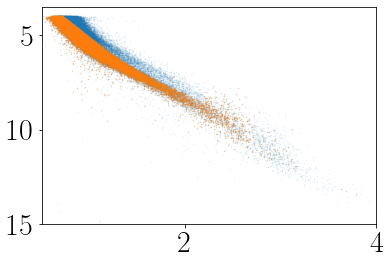

In [115]:
# plt.figure(figsize=(16, 9), dpi=200)
plt.plot(df0.bp_dered - df0.rp_dered, df0.abs_G, ".", alpha=.1, ms=1)
plt.plot(df1.bp_dered - df1.rp_dered, df1.abs_G, ".", alpha=.3, ms=1)
# plt.plot(gaia_mc.bp_dered - gaia_mc.rp_dered, gaia_mc.abs_G, ".", alpha=.3, ms=1)
plt.ylim(15, 3.5)
plt.xlim(.5, 4)

(6700, 2800)

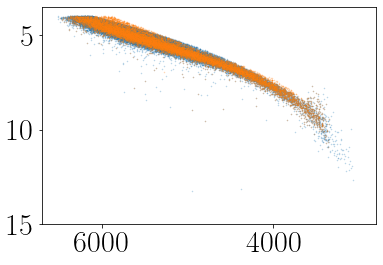

In [116]:
# plt.figure(figsize=(16, 9), dpi=200)

# plt.plot(df1.bp_dered - df1.rp_dered, df1.abs_G, ".", alpha=.3, ms=1)
# plt.plot(gaia_mc.bp_dered - gaia_mc.rp_dered, gaia_mc.abs_G, ".", alpha=.3, ms=1)

plt.plot(df1.color_teffs, df1.abs_G, ".", alpha=.3, ms=1)
plt.plot(gaia_mc.color_teffs, gaia_mc.abs_G, ".", alpha=.3, ms=1)

plt.ylim(15, 3.5)
plt.xlim(6700, 2800)

In [131]:
from kinematics_and_rotation.dispersion import select_stars

teff_bins = np.linspace(3000, 6500, 10)
mid_teff_bins = teff_bins[:-1] + .5*np.diff(teff_bins)
kep_masks = select_stars(df1, teff_bins, "color_teffs")
mc_masks = select_stars(gaia_mc, teff_bins, "color_teffs")

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


(6600, 2900)

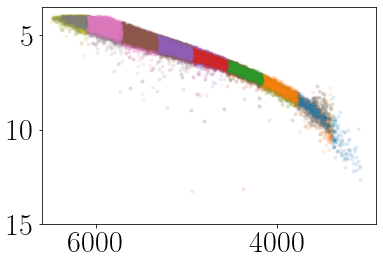

In [132]:
for m in kep_masks:
    plt.plot(df1.color_teffs.values[m], df1.abs_G.values[m], ".", alpha=.1)
for m in mc_masks:
    plt.plot(gaia_mc.color_teffs.values[m], gaia_mc.abs_G.values[m], ".", alpha=.1)
plt.ylim(15, 3.5)
plt.xlim(6600, 2900)

In [133]:
def mc_uncert(values, uncerts, nsamps):
    resamp_values = np.random.randn(len(values), nsamps)*uncerts[:, None] + values[:, None]
    meds = 1.5 * aps.median_absolute_deviation(resamp_values, axis=0)
    return np.std(meds)

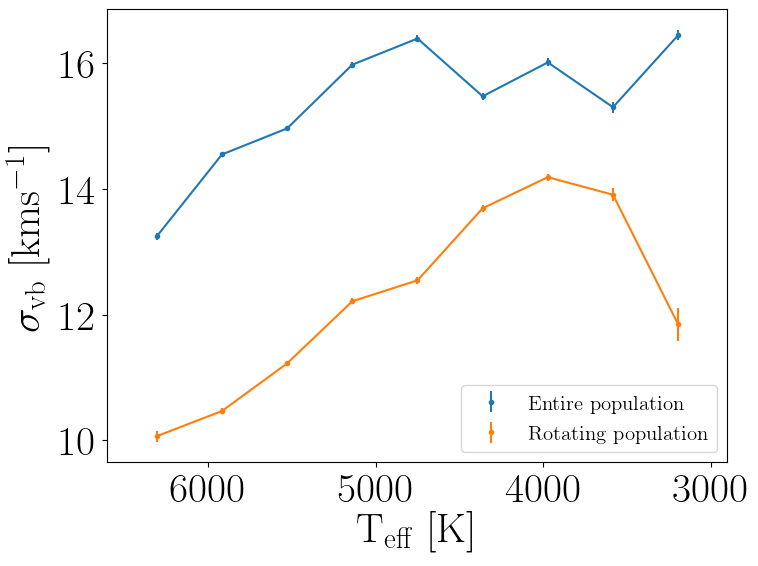

In [134]:
nsamps = 1000

all_sigmavb, all_err = [np.zeros(len(mc_masks)) for i in range(2)]
for i, m in enumerate(kep_masks):
    all_sigmavb[i] = 1.5 * aps.median_absolute_deviation(df1.vb.values[m])
    err = mc_uncert(df1.vb.values[m], df1.vb_err.values[m], 1000)
    all_err[i] = err
    
rot_sigmavb, rot_err = [np.zeros(len(mc_masks)) for i in range(2)]
for i, m in enumerate(mc_masks):
    rot_sigmavb[i] = 1.5 * aps.median_absolute_deviation(gaia_mc.vb.values[m])
    err = mc_uncert(gaia_mc.vb.values[m], gaia_mc.vb_err.values[m], 1000)
    rot_err[i] = err

plt.figure(figsize=(8, 6), dpi=100)
    
plt.errorbar(mid_teff_bins, all_sigmavb, yerr=all_err, fmt="C0.", label="$\mathrm{Entire~population}$")
plt.plot(mid_teff_bins, all_sigmavb, "C0")
    
plt.errorbar(mid_teff_bins, rot_sigmavb, yerr=rot_err, fmt="C1.", label="$\mathrm{Rotating~population}$")
plt.plot(mid_teff_bins, rot_sigmavb, "C1")

plt.legend()
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{\sigma_{vb}~[kms^{-1}]}$")
plt.xlim(6600, 2900);

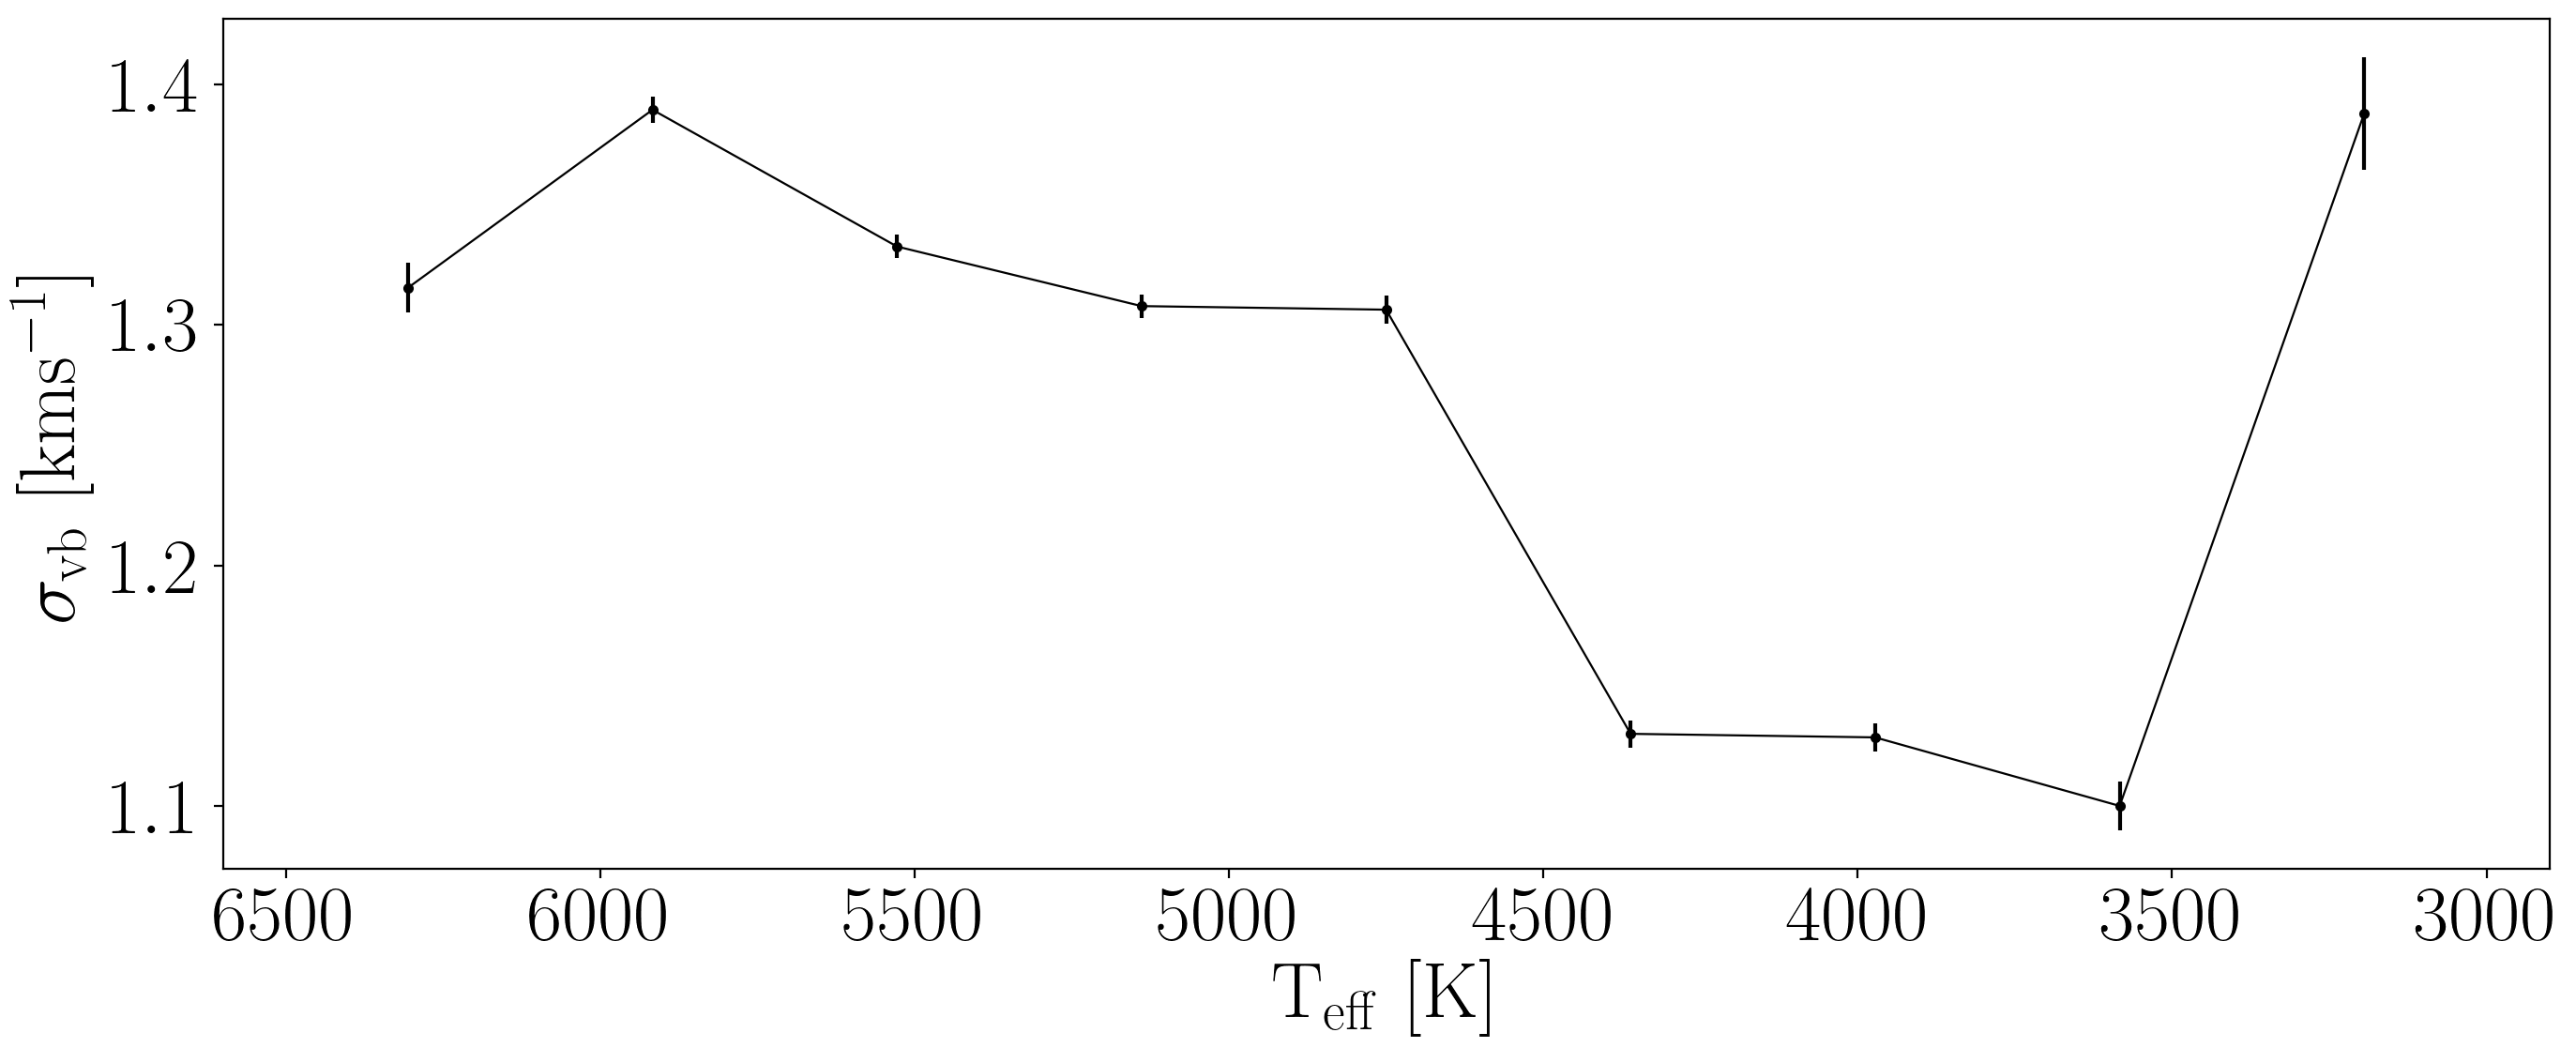

In [138]:
plt.figure(figsize=(16, 6), dpi=200)
    
plt.errorbar(mid_teff_bins, all_sigmavb/rot_sigmavb, yerr=np.sqrt(all_err**2 + rot_err**2)/rot_sigmavb, fmt="k.", label="$\mathrm{Entire~population}$")
plt.plot(mid_teff_bins, all_sigmavb/rot_sigmavb, "k", lw=.8)
    
# plt.errorbar(mid_teff_bins, rot_sigmavb, yerr=rot_err, fmt="C1.", label="$\mathrm{Rotating~population}$")
# plt.plot(mid_teff_bins, rot_sigmavb, "C1")

# plt.legend()
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{\sigma_{vb}~[kms^{-1}]}$")
plt.xlim(6600, 2900);
plt.savefig("field_comparison.pdf")
plt.savefig("field_comparison")

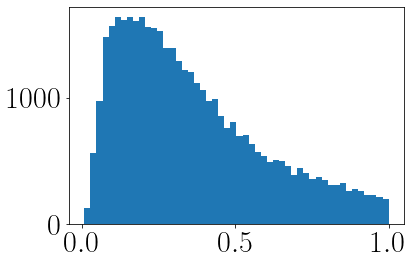

In [137]:
plt.hist(df1.vb_err.values, 50);